# Normalization scheme comparer

In [1]:
import os
import uproot
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import corner

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

plt.rcParams.update({'font.size': 16, 'lines.markersize' : 10})

In [4]:
# Don't rerun this!
resses = {}

In [5]:
t = time.perf_counter()
data_path = r'F:\Master\Data\pickles'
filename = r'data_D.2lep-jet.pkl'
jet_data = pd.read_pickle(os.sep.join([data_path, filename]))
print('Data load time:', time.perf_counter() - t, 'seconds.')

branches = ['jet_pt', 'jet_eta', 'jet_phi', 'jet_E']
jet_data = jet_data[branches]
dataset_name = 'D from pickle'
jet_branches = branches

Data load time: 1.4309297999989212 seconds.


Viewing the D from pickle
Number of jet four-momenta: 3898273


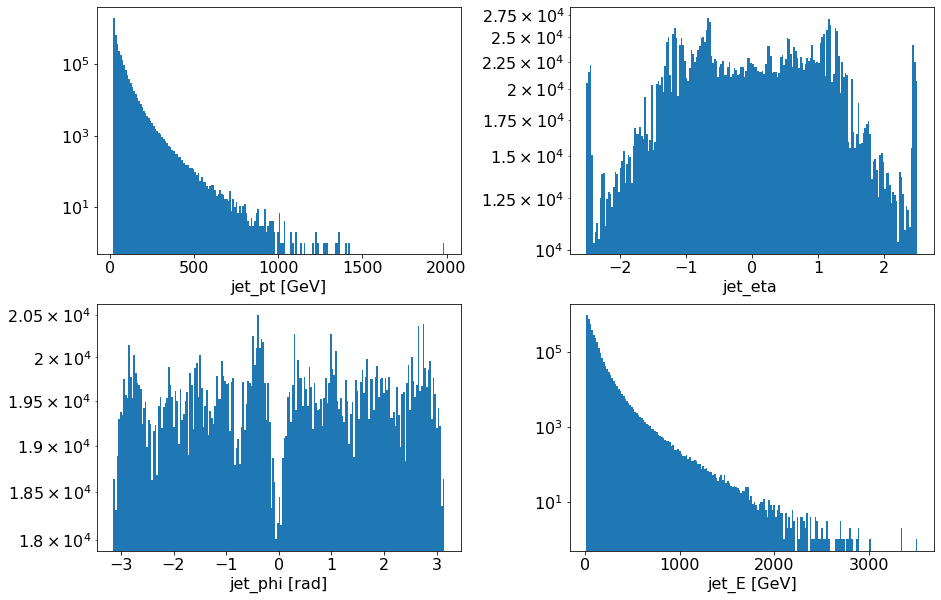

In [81]:
n_bins = 200

print('Viewing the ' + dataset_name)

units = ['[GeV]', '', '[rad]', '[GeV]']  
multiplier = [1e-3, 1, 1, 1e-3, 1, 1]

fig = plt.figure(figsize=(15, 10))
for i, branch in enumerate(jet_branches):
    plt.subplot(2, len(jet_branches) // 2, i+1)
    plt.hist(jet_data[branch] * multiplier[i], bins=n_bins)
    ax = plt.gca()
    ax.set_xlabel(branch + ' ' + units[i])
    plt.yscale('log')
plt.subplots_adjust(wspace=0.3)
    
n_jets = len(jet_data)

print('Number of jet four-momenta:', n_jets)

### Normalize data and divide into training and testing datasets
Autoencoder performance depends on the scale of the input data. In this example, all variables are normalized to be in approximately the same range.

Viewing normalized data.


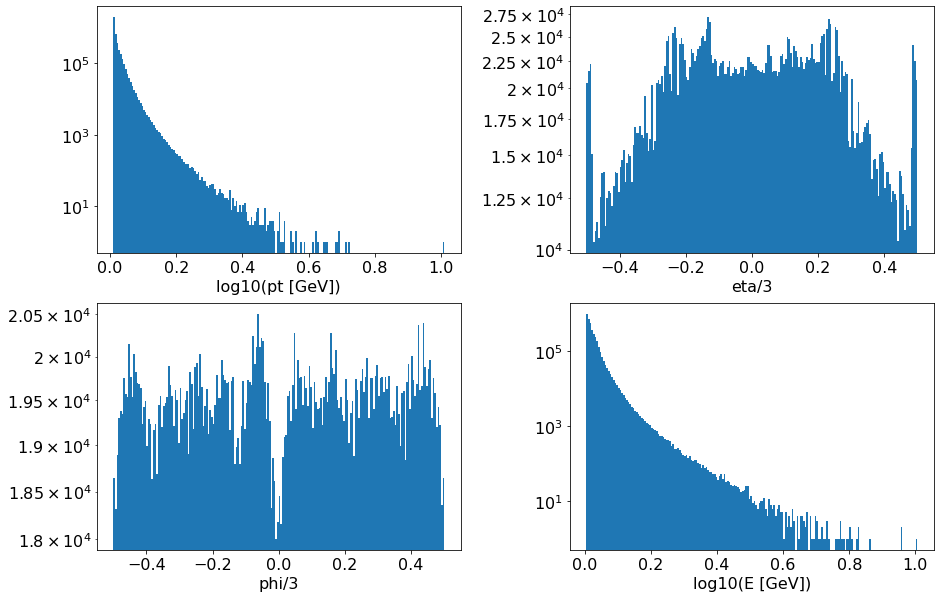

In [82]:
from satools.satools import normalize, make_DataLoaders

scheme = 'div_by_range'

dataset, norm_params = normalize(jet_data, scheme=scheme)
dataset = dataset.values

# The dataset is split so that 80% becomes training data and the remaining 20% testing data
train_idxs = (0, int(len(dataset) * 4 / 5))
test_idxs = (train_idxs[1], len(dataset))

train = dataset[train_idxs[0]:train_idxs[1]]
test = dataset[test_idxs[0]:test_idxs[1]]

batch_size = 256

dls = make_DataLoaders(train, test, batch_size)

labels = ['log10(pt [GeV])', 'eta/3', 'phi/3', 'log10(E [GeV])']

print('Viewing normalized data.')

fig = plt.figure(figsize=(15, 10))
for i, branch in enumerate(jet_branches):
    plt.subplot(2, len(jet_branches) // 2, i+1)
    plt.hist(dataset[:, i], bins=n_bins)
    ax = plt.gca()
    ax.set_xlabel(labels[i])
    plt.yscale('log')
plt.subplots_adjust(wspace=0.3)

### Single jet AE
Define model for the single-jet AE and instantiate it.

In [32]:
class Model(nn.Module):
    def __init__(self, n_features=4, latent_space_size=3):
        super(Model, self).__init__()      
        
        self.n_features = n_features
        self.latent_space_size = latent_space_size
        
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, latent_space_size)
        self.de1 = nn.Linear(latent_space_size, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)
        self.act = nn.Tanh()
    
    def encode(self, x):
        return self.en4(self.act(self.en3(self.act(self.en2(self.act(self.en1(x)))))))
    
    def decode(self, x):
        return self.de4(self.act(self.de3(self.act(self.de2(self.act(self.de1(self.act(x))))))))
    
    def forward(self, x, mode = 'both'):
        assert mode in ['both', 'encode', 'decode'], 'model expects keyword mode to be \'encode\', \'decode\' or \'both\'.'
        if mode == 'encode':
            return self.encode(x)
        elif mode == 'decode':
            return self.decode(x)
        else:
            z = self.encode(x)
            return self.decode(z)
    
    def describe(self):
        description = ''
        for module in [self.en1, self.en2, self.en3, self.en4, self.de1, self.de2, self.de3, self.de4]:
            description += str(module.in_features) + '-'
        description += str(module.out_features) + ', activation function: ' + str(self.act)
        return description

In [33]:
n_features = jet_data.shape[1]
latent_space_size = 3
if not latent_space_size < n_features:
    print('WARNING! Dimensionality of latent space is not lower than that of input data! Is this intended?')

print('Number of features in input data:', n_features)
print('Latent space size:', latent_space_size)
model = Model(n_features=n_features, latent_space_size=latent_space_size)
model.to('cpu')
print(model.describe())

Number of features in input data: 4
Latent space size: 3
4-200-100-50-3-50-100-200-4, activation function: Tanh()


### Initializing the network, single-vector encoding

In [34]:
# Set up the model and learner

loss_func = nn.MSELoss()

weight_decay = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_func, cbs=recorder)

### Load a saved model...

In [35]:
# Option to load a model
#run_20211026113204_d2lep_dim_4_same_event_1_3 # div_by_range
#run_20211026114307_d2lep_dim_4_same_event_1_3 # log
#run_20211026114315_d2lep_dim_4_same_event_1_3 # zero_one
load_filename = os.sep.join([r'F:\Master\Data\storage\models', 'run_20211026113204_d2lep_dim_4_same_event_1_3'])
load = True
if load:
    learn.load(load_filename)
    print('Loaded model', load_filename)

Loaded model F:\Master\Data\storage\models\run_20211026113204_d2lep_dim_4_same_event_1_3


In [ ]:
from satools.satools import unnormalize

orig = test.copy()
pred = model(torch.tensor(orig, dtype=torch.float)).detach().numpy()

orig = pd.DataFrame(orig)
orig.columns = branches
pred = pd.DataFrame(pred)
pred.columns = branches

orig = unnormalize(orig, norm_params, scheme=scheme).values
pred = unnormalize(pred, norm_params, scheme=scheme).values

### Alternatively, load saved results for original and prediction data

In [27]:
schemes = ['div_by_range', 'log', 'zero_one']
model_names = ['run_20211026113204_d2lep_dim_4_same_event_1_3',
               'run_20211026114307_d2lep_dim_4_same_event_1_3',
               'run_20211026114315_d2lep_dim_4_same_event_1_3']

path = r'F:\Master\Data\storage\orig-pred'
origs = {}
preds = {}
resses = {}
for i, model_name in enumerate(model_names):
    filename = os.sep.join([path, model_name + '_orig-pred.pkl'])
    data_tuple = pd.read_pickle(filename)
    origs[schemes[i]] = data_tuple[0]
    preds[schemes[i]] = data_tuple[1]
    resses[schemes[i]] = (data_tuple[1] - data_tuple[0]).values
    resses[schemes[i]][:, 0] /= data_tuple[0].iloc[:, 0]
    resses[schemes[i]][:, 3] /= data_tuple[0].iloc[:, 3]
    
orig = origs[schemes[0]].values
pred = preds[schemes[0]].values

### Create histograms comparing input testing data to AE reconstruction

Viewing the D from pickle
Number of jets in test set: 779655
No model loaded.


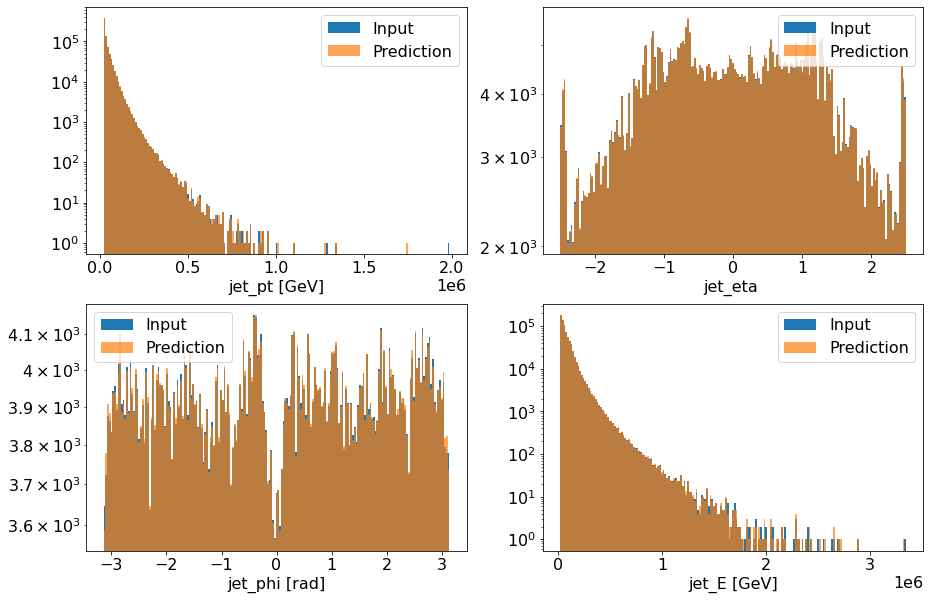

In [21]:
units = ['[GeV]', '', '[rad]', '[GeV]']

branches = jet_branches # did I mess this up=?

n_bins = 200
fig = plt.figure(figsize=(15, 10))
for i in range(orig.shape[1]):
    plt.subplot(2, 2, i+1)
    bins = np.linspace(min(min(orig[:, i]), min(pred[:, i])), max(max(orig[:, i]), max(pred[:, i])), n_bins)
    _ = plt.hist(orig[:, i], bins=bins, density=False, label='Input')
    _ = plt.hist(pred[:, i], bins=bins, alpha=0.7, density=False, label='Prediction')
    plt.xlabel(branches[i] + ' ' + units[i])
    plt.yscale('log')
    plt.legend()

print('Viewing the ' + dataset_name)
print('Number of jets in test set:', len(orig))

try:
    print('Using AE architecture ' + model.describe())
    if load:
        print('Model name: ' + load_filename)
except:
    print('No model loaded.')

### Calculate responses and residuals
The standard deviation of the responses and residuals should be small. In addition, the distributions of responses and residuals should ideally be zero-centered.

jet_pt response mean: -0.00014359257
jet_pt response std: 0.0018746847

jet_eta residual mean: -1.1879416e-06
jet_eta residual std: 0.00022887041

jet_phi residual mean: 1.1906381e-07
jet_phi residual std: 0.00029698998

jet_E response mean: 0.00022095979
jet_E response std: 0.0021573398



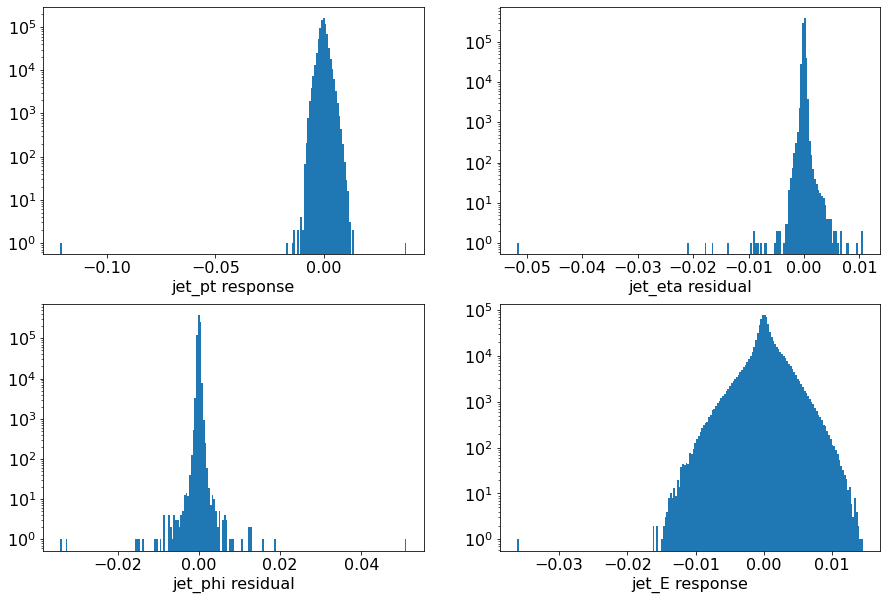

In [22]:
res = pred - orig
res[:, 0] /= orig[:, 0]
res[:, 3] /= orig[:, 3]

res_str = ['response', 'residual', 'residual', 'response']
n_bins = 200
ranges = [(min(res[:, i]), max(res[:, i])) for i in range(res.shape[1])]
limits = [np.linspace(a, b, n_bins) for (a, b) in ranges]

bin_edges = {}
bin_counts = {}
bin_max_ixs = {}

fig = plt.figure(figsize=(15, 10))
for i in range(res.shape[1]):
    plt.subplot(2, 2, i+1)
    branch = branches[i]
    bin_counts[branch], bin_edges[branch], _ = plt.hist(res[:, i], bins=limits[i], density=False)
    bin_max_ixs[branch] = np.where(bin_counts[branch] == bin_counts[branch].max())
    
    
    plt.xlabel(branch + ' ' + res_str[i])
    plt.yscale('log')
    print(branches[i] + ' ' + res_str[i] + ' mean:', res[:, i].mean())
    print(branches[i] + ' ' + res_str[i] + ' std:', res[:, i].std())
    print()

In [38]:
#resses[scheme] = res # This is used if models are loaded separately and used to calculate predictions, instead of loading stored original and predicted values.

In [28]:
means = {}
stds = {}
for scheme in schemes:
    means[scheme] = {}
    stds[scheme] = {}
    print('\n'+scheme)
    for i, branch in enumerate(branches):
        means[scheme][branch] = resses[scheme][:, i].mean()
        stds[scheme][branch] = resses[scheme][:, i].std()
        print(branch)
        print('mean: {:.3e}'.format(means[scheme][branch]))
        print('std: {:.3e}'.format(stds[scheme][branch]))


div_by_range
jet_pt
mean: -1.436e-04
std: 1.875e-03
jet_eta
mean: -1.188e-06
std: 2.289e-04
jet_phi
mean: 1.191e-07
std: 2.970e-04
jet_E
mean: 2.210e-04
std: 2.157e-03

log
jet_pt
mean: -9.863e-05
std: 1.586e-03
jet_eta
mean: 1.241e-06
std: 1.096e-03
jet_phi
mean: 3.129e-07
std: 3.339e-04
jet_E
mean: 1.006e-04
std: 1.599e-03

zero_one
jet_pt
mean: -1.158e-04
std: 1.795e-03
jet_eta
mean: -1.418e-06
std: 2.339e-04
jet_phi
mean: -2.836e-07
std: 3.468e-04
jet_E
mean: 3.077e-04
std: 2.622e-03


### Visualize correlations between the responses/residuals of the different variables
This can for example be used to see if the network is trading off accuracy in one variable for another.

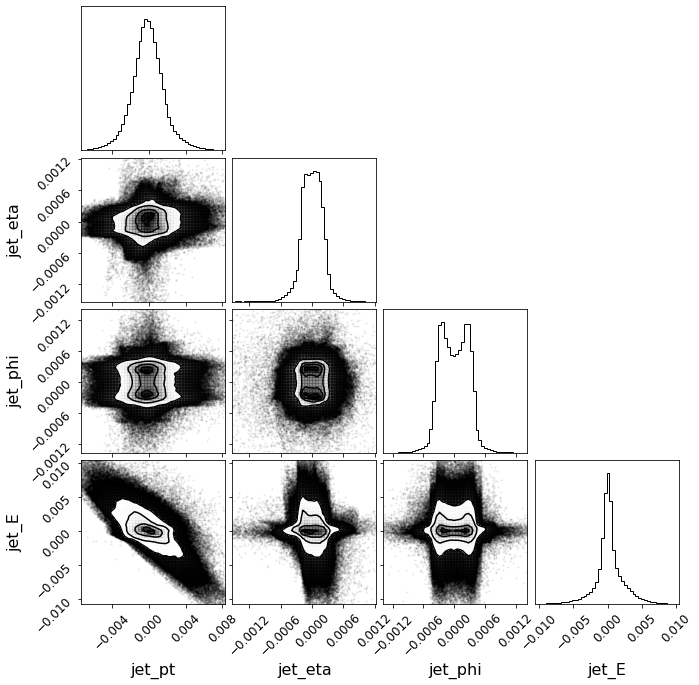

In [32]:
fig = corner.corner(res, range=[0.999 for _ in range(4)], labels=branches, bins=50, labelpad=0.1)
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)

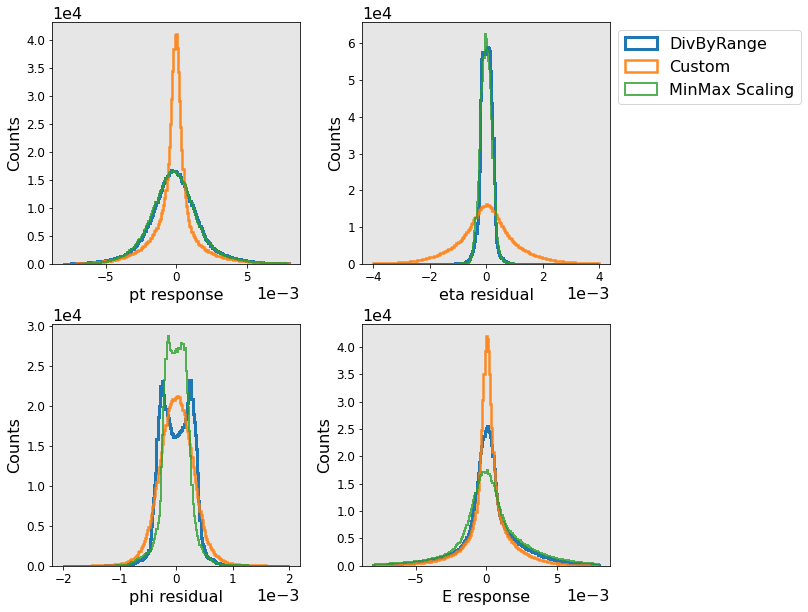

In [33]:
# view the responses and residuals of the four-momentum variables for the three AEs using different normalization schemes

schemes = ['div_by_range', 'log', 'zero_one']
labels = ['DivByRange', 'Custom', 'MinMax Scaling']
fig = plt.figure(figsize=(10, 10))
xlabels = ['pt response', 'eta residual', 'phi residual', 'E response']
limits = [(-0.008, 0.008), (-0.004, 0.004), (-0.002, 0.002), (-0.008, 0.008)]

for j, scheme in enumerate(schemes):
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.hist(resses[scheme][:, i], bins=np.linspace(limits[i][0], limits[i][1], 200), alpha=1-j/10, label=labels[j], histtype='step', linewidth=3-j*.5)
        #plt.yscale('log')
        if i == 1:
            plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel(xlabels[i])
        plt.ylabel('Counts')
        ax = plt.gca()
        ax.set_facecolor((.9, .9, .9))
        ax.tick_params(axis='both', labelsize=12)
        plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))

plt.subplots_adjust(wspace=0.25, hspace=0.25)

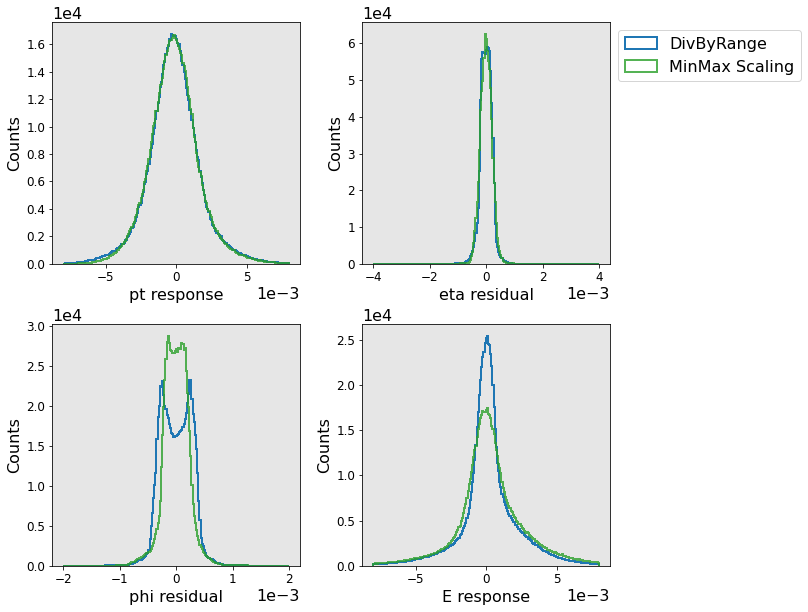

In [34]:
cmap = plt.get_cmap('tab10')
colors = [cmap.colors[i] for i in range(3)]
fig = plt.figure(figsize=(10, 10))
xlabels = ['pt response', 'eta residual', 'phi residual', 'E response']
limits = [(-0.008, 0.008), (-0.004, 0.004), (-0.002, 0.002), (-0.008, 0.008)]
for j, scheme in enumerate(schemes):
    if not scheme == 'log':
        for i in range(4):
            plt.subplot(2, 2, i+1)
            plt.hist(resses[scheme][:, i], bins=np.linspace(limits[i][0], limits[i][1], 200), alpha=1-j/10, label=labels[j], histtype='step', linewidth=2, color=colors[j])
            #plt.yscale('log')
            if i == 1:
                plt.legend(bbox_to_anchor=(1, 1))
            plt.xlabel(xlabels[i])
            plt.ylabel('Counts')
            ax = plt.gca()
            ax.set_facecolor((.9, .9, .9))
            ax.tick_params(axis='both', labelsize=12)
            plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))

plt.subplots_adjust(wspace=0.25, hspace=0.25)

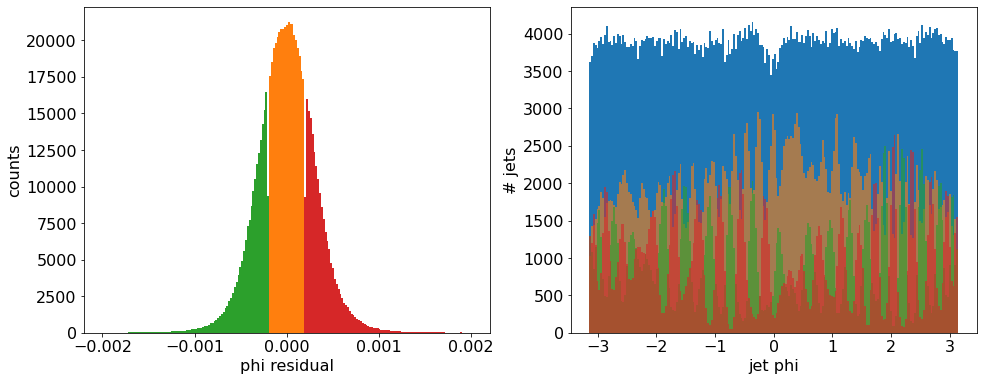

In [108]:
# deeper dive into the split-peak behaviour of the phi residuals

scheme = 'log'
mask_center = (resses[scheme][:, 2] > -0.0002) & (resses[scheme][:, 2] < 0.0002)
mask_neg = (resses[scheme][:, 2] < -0.0002)
mask_pos = (resses[scheme][:, 2] > 0.0002)
masks = [mask_center, mask_neg, mask_pos]
fig = plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
counts, edges, _ = plt.hist(resses[scheme][:, 2], bins=np.linspace(limits[2][0], limits[2][1], 200), alpha=0)
for mask in masks:
    _ = plt.hist(resses[scheme][:, 2][mask], bins=edges)
plt.xlabel('phi residual')
plt.ylabel('counts')
    
plt.subplot(1,2,2)
_ = plt.hist(origs[scheme].iloc[:,2], bins=200)
_ = plt.hist(origs[scheme].iloc[:,2][mask_center], bins=200, alpha=0.6)
_ = plt.hist(origs[scheme].iloc[:,2][mask_neg], bins=200, alpha=0.6)
_ = plt.hist(origs[scheme].iloc[:,2][mask_pos], bins=200, alpha=0.6)
plt.xlabel('jet phi')
plt.ylabel('# jets');

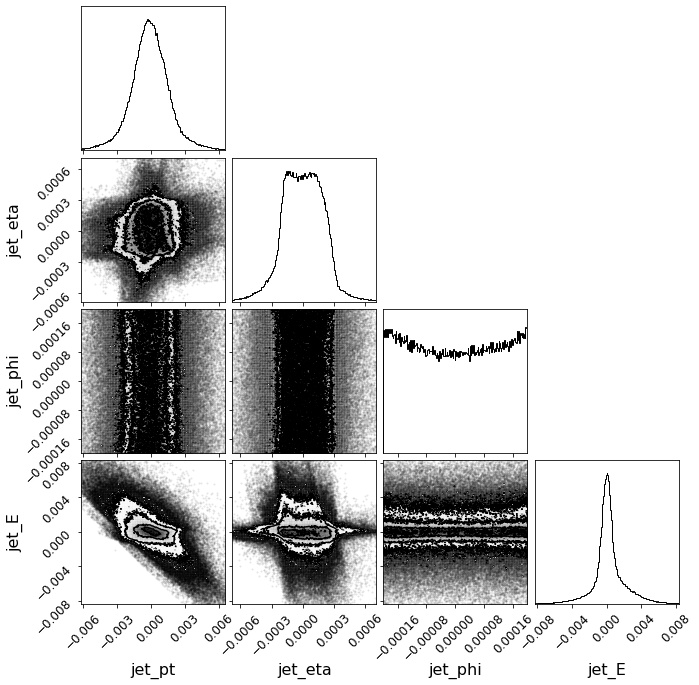

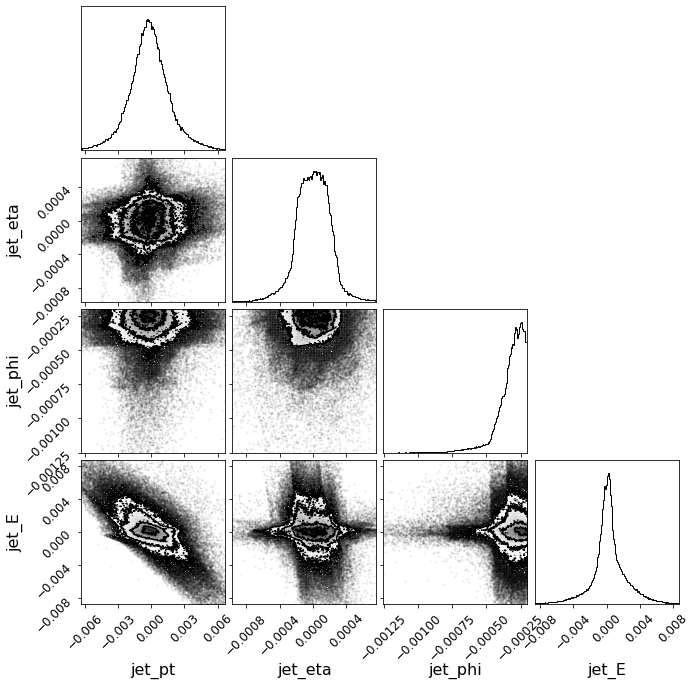

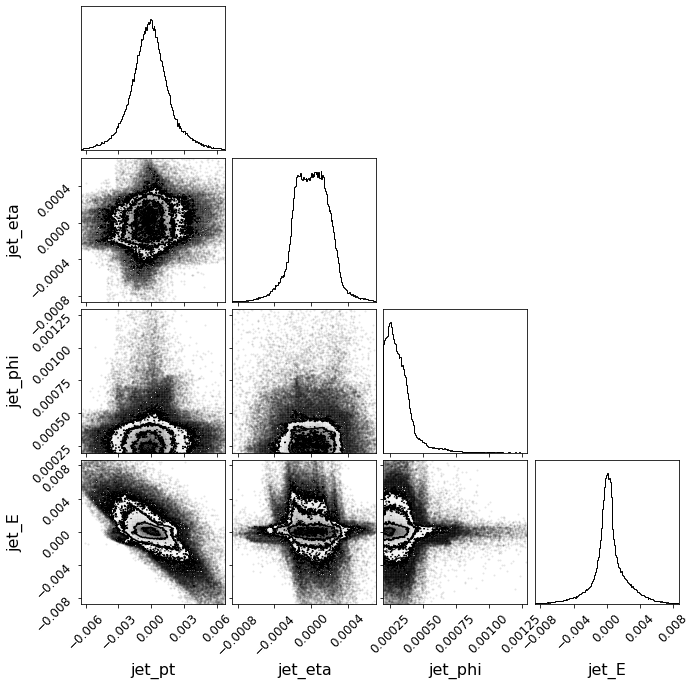

In [54]:
for mask in masks:
    fig = corner.corner(resses['div_by_range'][mask], bins=200, range=[0.995 for _ in range(4)], labels=branches, labelpad=0.1)
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)

Viewing div_by_range
Viewing log
Viewing zero_one


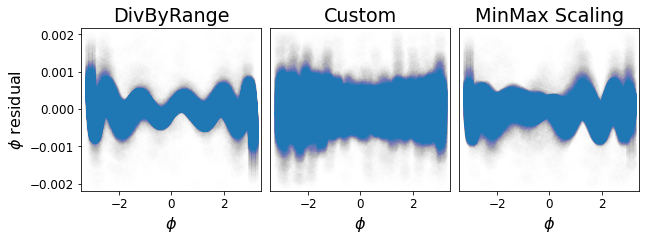

In [124]:
fig = plt.figure(figsize=(10, 3))
for i, scheme in enumerate(schemes):
    plt.subplot(1, 3, i+1)
    mask = (resses[scheme][:, 2] < 0.002) & (resses[scheme][:, 2] > -0.002)
    plt.scatter(origs[scheme].iloc[:, 2][::2][mask[::2]], resses[scheme][:, 2][::2][mask[::2]], alpha=0.002)
    plt.xlabel('$\phi$')
    plt.title(labels[i])
    if i == 0:
        plt.ylabel('$\phi$ residual');
    else:
        plt.yticks([])
    print('Viewing', scheme)
    plt.gca().tick_params(axis='both', labelsize=12)
plt.subplots_adjust(wspace=0.05)